# Selecting Praesepe members, compiling data and fitting a gyrochronology relation

This notebook reproduces figures in the paper.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
from astropy.io import fits

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 20,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Douglas Praesepe rotation period catalog.

In [40]:
douglas = pd.read_csv("data/praesepe_douglas.csv", skiprows=89)
douglas.head()

,Name,EPIC,Mass,r'mag,Kmag,Prot1,Pw1,Q1,Clean?,Sig,...,SmAmp,P,Kpmag,PrCat,PCat,All,2M,Simbad,_RA,_DE
0,KW547,211898181,1.05,11.65,9.70,,,2,,,...,,,11.68,0,0,All,2M,Simbad,130.157851,18.700121
1,A 448,211845572,0.15,18.59,14.57,,,2,,,...,,,17.36,0,0,All,2M,Simbad,129.143078,17.957611
2,KW548,212004731,0.80,11.81,10.59,3.96,0.1085,0,N,0.00838,...,0.02363,2,11.79,0,0,All,2M,Simbad,130.815494,20.333748
3,JC201,211930461,0.73,13.49,10.76,14.59,0.8391,0,Y,0.00816,...,0.38429,2,13.49,0,1,All,2M,Simbad,130.088905,19.181773
4,,212094548,0.16,19.52,14.25,6.60,0.0089,1,N,0.00521,...,0.77485,2,18.71,0,1,All,2M,Simbad,130.281121,21.915739


Format the data: convert periods from strings to floats and get rid of spaces in the dataframe

In [41]:
prots = []
for p in douglas.Prot1.values:
    if p == "     ":
        prots.append(0.)
    else:
        prots.append(float(p))
douglas["prot"] = np.array(prots)

Load the Bedell Gaia-K2 crossmatch (downloaded from gaia-kepler.fun) and ensmallen it so it's a managable size.

In [42]:
with fits.open('data/k2_dr2_1arcsec.fits') as data:
    bedell = pd.DataFrame(data[1].data)

In [43]:
# def mag_err(flux, flux_err, mag):
#     F1 = flux + flux_err
#     F2 = flux
#     return np.log10(F1/F2)/0.4

def color_err(c):
    c_err = np.zeros(len(c))
    bright = c < 13
    medium = (13 < c) * (c < 17)
    faint = 17 <= c
    c_err[bright] = np.ones(len(c_err[bright]))*.002
    c_err[medium] = np.ones(len(c_err[medium]))*.01
    c_err[faint] = np.ones(len(c_err[faint]))*.2
    return c_err


def photometric_noise(G, bp, rp):
    G_err = np.zeros(len(G))
    bright = G < 13
    medium = (13 < G) * (G < 17)
    faint = 17 <= G
    G_err[bright] = np.ones(len(G_err[bright]))*.0003
    G_err[medium] = np.ones(len(G_err[medium]))*.002
    G_err[faint] = np.ones(len(G_err[faint]))*.01

    bp_err = color_err(bp)
    rp_err = color_err(rp)
    
    parallax_err = np.zeros(len(G))
    bright = G < 15
    medium = (15 < G) * (G < 17)
    faint = (17 < G) * (G < 20)
    ultra_faint = 21 <= G
    parallax_err[bright] = .03  # milliarcseconds
    parallax_err[medium] = .1
    parallax_err[faint] = .7
    parallax_err[ultra_faint] = 2
    
    return G_err, bp_err, rp_err, parallax_err

c5_mask = bedell.k2_campaign_str.values == "5"

G_err, bp_err, rp_err, _ = photometric_noise(bedell.phot_g_mean_mag.values[c5_mask],
                                             bedell.phot_bp_mean_mag.values[c5_mask],
                                             bedell.phot_rp_mean_mag.values[c5_mask])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


In [44]:
c5 = pd.read_csv("data/c5_gaia.csv")

Text(0, 0.5, 'Dec')

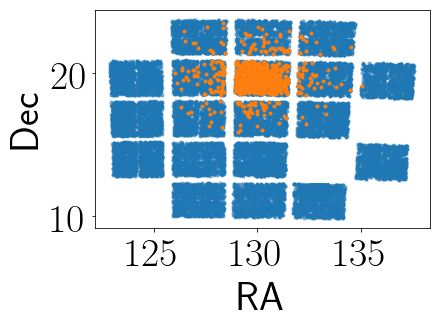

In [7]:
plt.plot(c5.ra, c5.dec, ".", alpha=.5)
plt.plot(douglas._RA, douglas._DE, ".")
plt.xlabel("RA")
plt.ylabel("Dec")

Just plot the crossmatched stars.

In [8]:
df = pd.merge(c5, douglas, on="EPIC", how="inner")
df.drop_duplicates("EPIC", inplace=True)
print(np.shape(c5), np.shape(douglas), np.shape(df))

(27500, 10) (794, 29) (757, 38)


Text(0, 0.5, 'Dec')

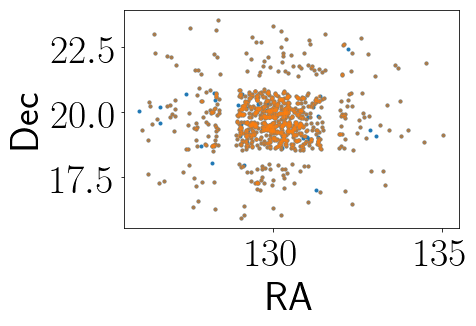

In [9]:
plt.plot(douglas._RA, douglas._DE, ".")
plt.plot(df.ra, df.dec, ".", alpha=.5)
plt.xlabel("RA")
plt.ylabel("Dec")

Now add the angus2015 models

In [27]:
def bv_2_bprp(bv):
    """
    Numbers from https://arxiv.org/pdf/1008.0815.pdf
    """
    a, b, c, d = .0981, 1.4290, -.0269, .0061  # sigma = .43
    return a + b*bv + c*bv**2 + d*bv**3


def bprp_2_bv(bprp):
    """
    Try to find the analytic version of this, please!
    """
    bv_iter = np.linspace(0., 2., 10000)
    bprp_pred = [bv_2_bprp(bv) for bv in bv_iter]
    diffs = bprp - np.array(bprp_pred)
    return bv_iter[np.argmin(diffs**2)]


# def gyro_model(log10_age, bv):
#     """
#     Given a B-V colour and an age, predict a rotation period.
#     Returns log(age) in Myr.
#     parameters:
#     ----------
#     logage: (array)
#         The log age of a star: log10(age) in years.
#     bv: (array)
#         The B-V colour of a star.
#     """
#     age_myr = (10**log10_age)*1e-6
    
#     a, b, c, n = [.4, .31, .45, .55]
    
#     # return a*(age_myr)**n * (bv - c)**b
#     log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
#     return 10**log_P

import stardate.lhf as sdl

xs = np.linspace(-.25, .6, 100)
bv, log_periods_praesepe, log_periods_sun, log_sigs = [np.zeros_like(xs) for i in range(4)]
for i, _x in enumerate(xs):
    bv[i] = bprp_2_bv(10**_x)
    log_periods_praesepe[i] = sdl.gyro_model(np.log10(625*1e6), bv[i])
    log_periods_sun[i] = sdl.gyro_model(np.log10(4.56*1e9), bv[i])
    log_sigs[i] = sdl.sigma(bv[i], 355)

periods_praesepe = 10**log_periods_praesepe
periods_sun = 10**log_periods_sun
sig_lower_p = 10**(log_periods_praesepe - log_sigs)
sig_upper_p = 10**(log_periods_praesepe + log_sigs)
sig_lower_s = 10**(log_periods_sun - log_sigs)
sig_upper_s = 10**(log_periods_sun + log_sigs)

print(bv_2_bprp(.65))
print(bprp_2_bv(.82))

1.0172599624999998
0.5094509450945095


In [ ]:
sim_df = pd.read_csv("data/simulated_data.csv")
predicted_bprp = []
for i in range(len(sim_df)):
    predicted_bprp.append(bprp_2_bv(sim_df.BP[i] - sim_df.RP[i]))

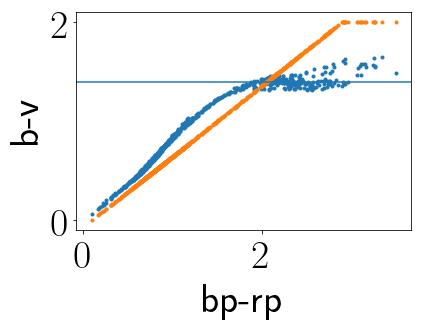

In [38]:
plt.plot(sim_df.BP - sim_df.RP, sim_df.B - sim_df.V, ".")
plt.plot(sim_df.BP - sim_df.RP, predicted_bprp, ".")
plt.xlabel("bp-rp")
plt.ylabel("b-v")
plt.axhline(1.4)

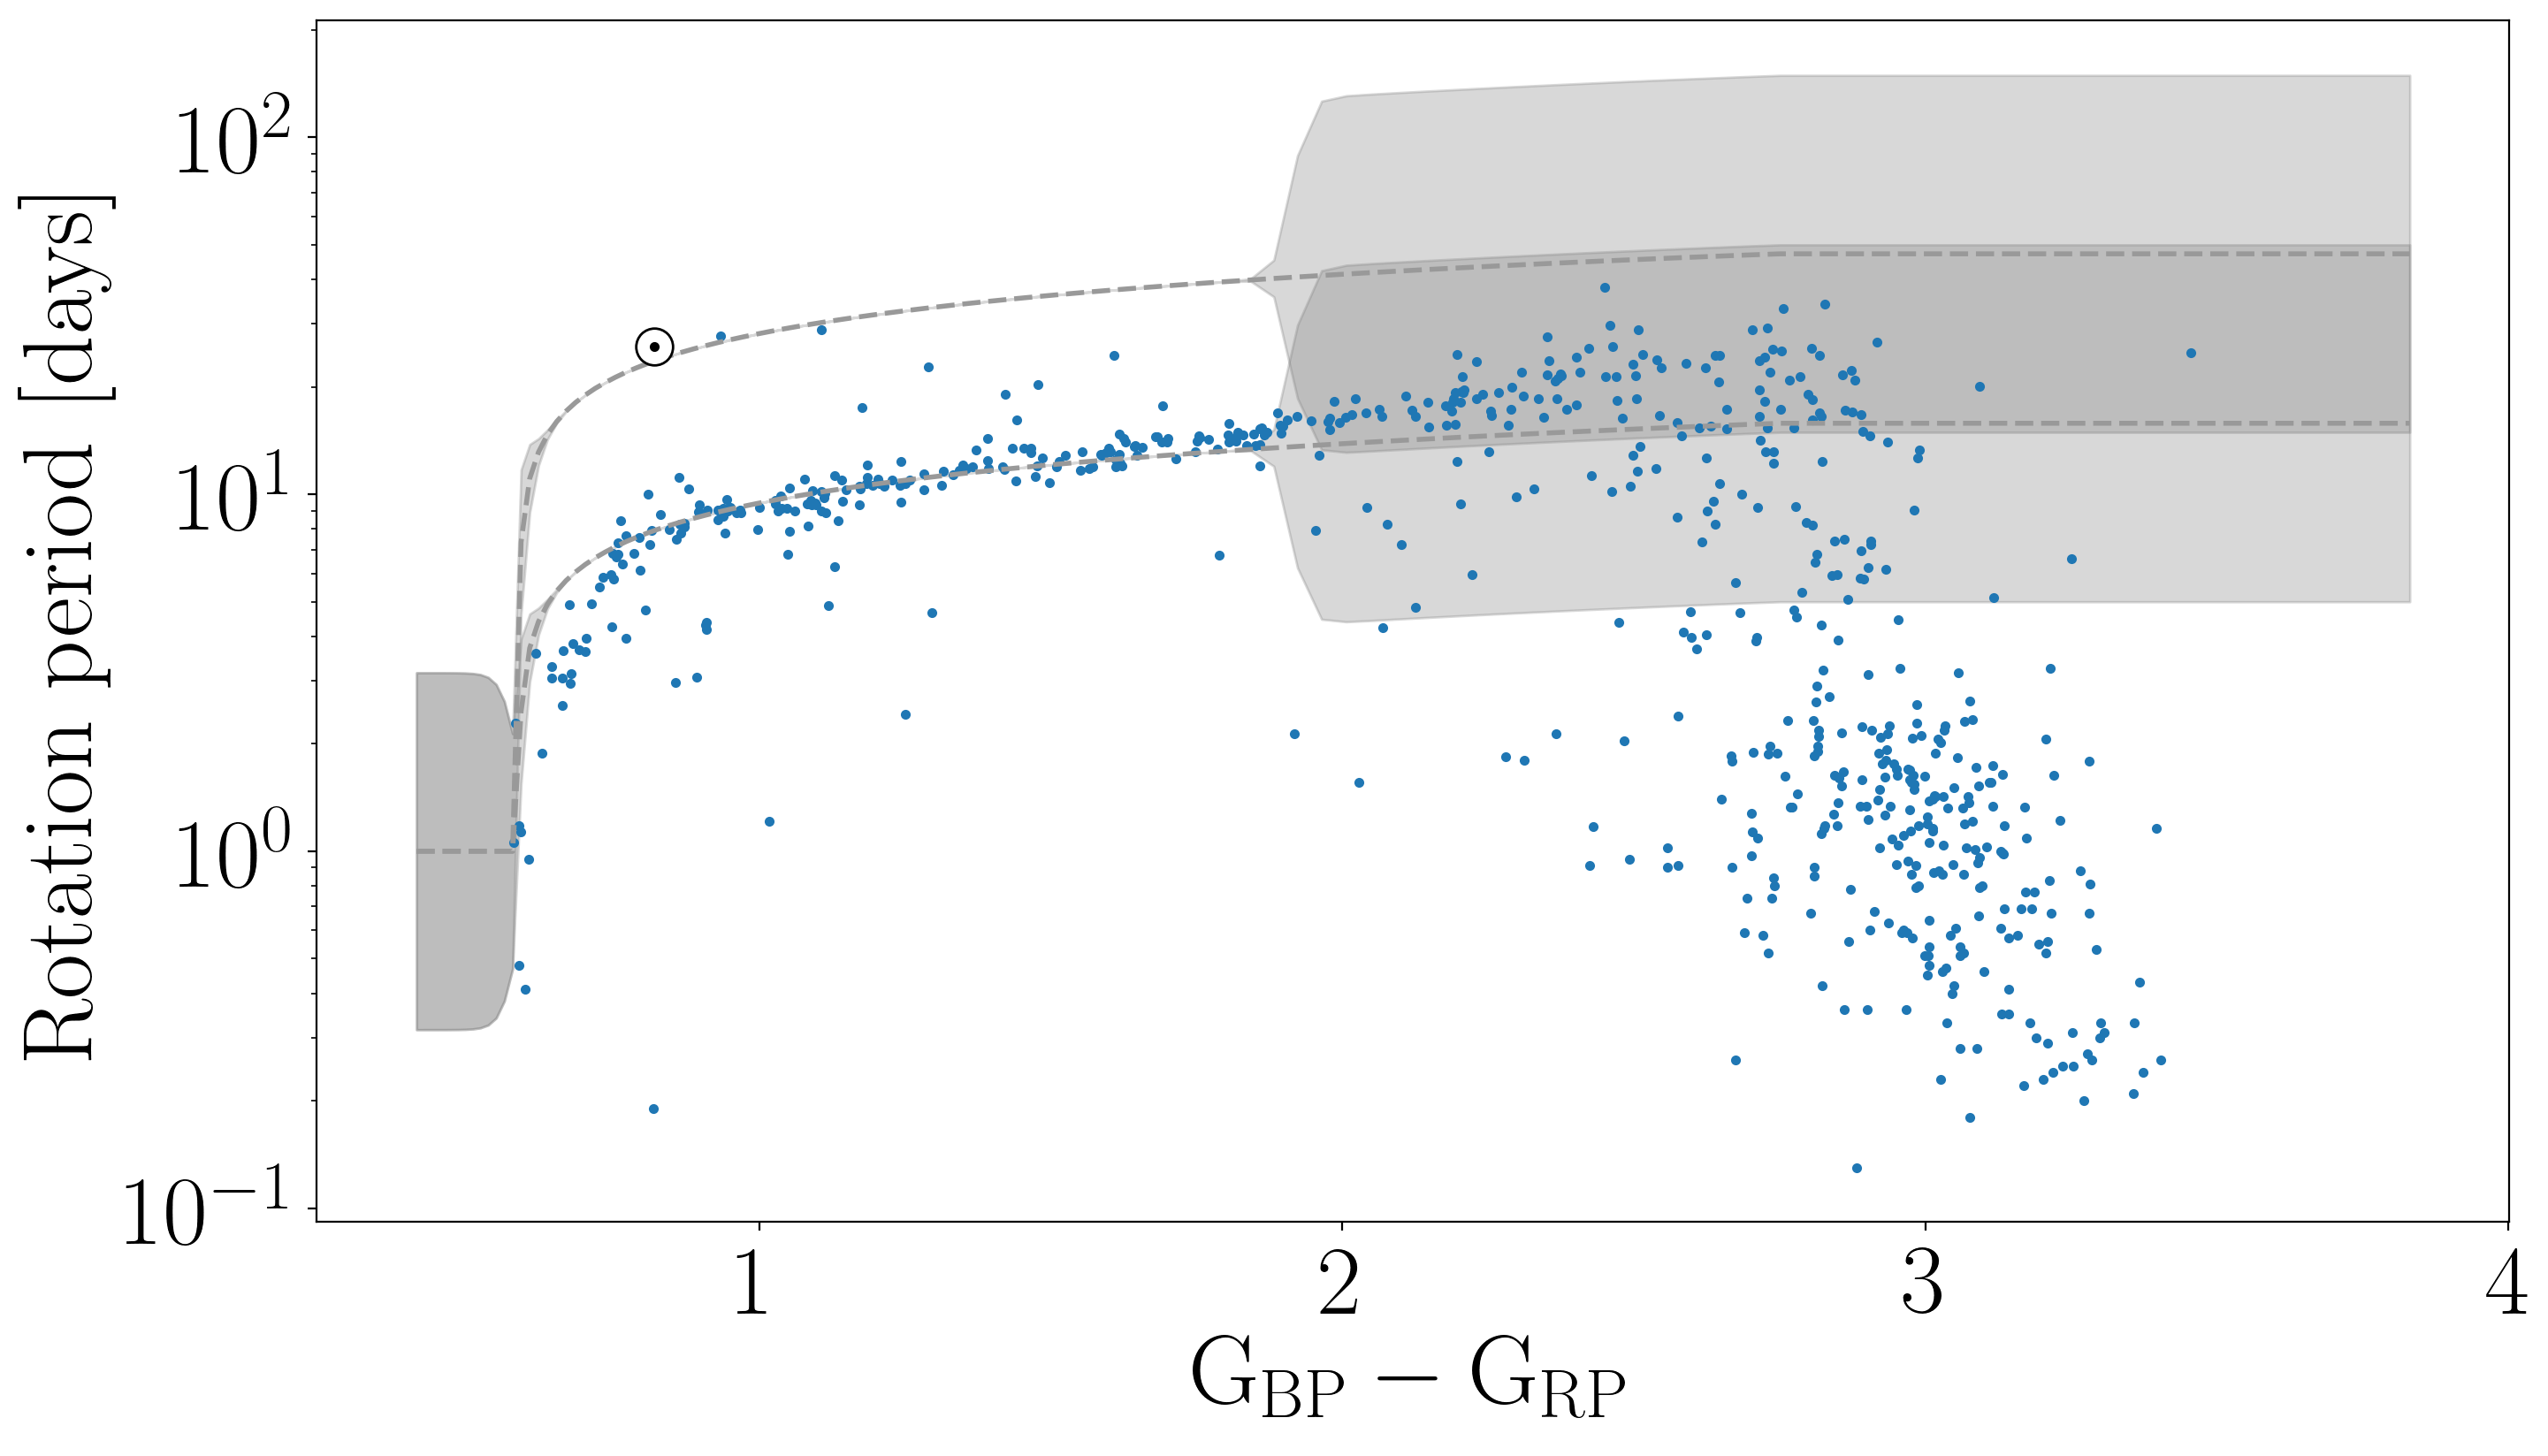

In [30]:
plt.figure(figsize=(16, 9), dpi=200)

# Full cluster
# plt.loglog(gaia_color, df.prot, "wo", ms=5, markeredgecolor="tab:orange", 
#           label="$\mathrm{Outliers~and~cool~stars}$")
# plt.loglog(gaia_color[~m_mask], df.prot[~m_mask], "wo", markeredgecolor="tab:orange", ms=5,
#           label="$\mathrm{Outliers~and~cool~stars}$")
# plt.axvline(Mdwarf_cut, color="k", alpha=.5, lw=1)

plt.plot(df.bp-df.rp, df.prot, ".", rasterized=True, label=None)

# Sigma clipped
# plt.plot(10**x_clipped, 10**y_clipped, ".", ms=11, color="tab:blue", label="$\mathrm{Used~during~fit}$")

# Sun
plt.plot(sun_color, sun_prot, "wo", markeredgecolor="k", ms=15, zorder=3, rasterized=True)
plt.plot(sun_color, sun_prot, ".k", zorder=3, rasterized=True)  # Casagrande 2018

# model
# plt.loglog(10**xs, 10**(p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(praesepe_age)),
#          color="k", ls="--", lw=2, zorder=2, label="$\mathrm{Praesepe~fit~(this~work)}$")
# plt.loglog(10**xs, 10**(p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(sun_age)),
#          color="k", ls="--", lw=2, zorder=0, label="$\mathrm{Praesepe~fit~(this~work)}$")

plt.plot(10**xs-.15, periods_praesepe, color=".6", ls="--", lw=2, ms=35, rasterized=True)
plt.fill_between(10**xs-.15,  sig_lower_p, sig_upper_p, color=".5", alpha=.3)
#, label="$\mathrm{Angus~et ~al.~(2015)}$")
plt.plot(10**xs-.15, periods_sun, color=".6", ls="--", lw=2, rasterized=True)
plt.fill_between(10**xs-.15,  sig_lower_s, sig_upper_s, color=".5", alpha=.3)


# Floof
plt.yscale("log")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
# plt.legend()
plt.savefig("with_angus_gyrochrones.pdf")

Save data files.

In [91]:
G_err = np.zeros(len(df.G.values))
bright = df.G.values < 13
G_err[bright] = np.ones(len(G_err[bright]))*.0003
medium = (13 < df.G.values) * (df.G.values < 17)
G_err[medium] = np.ones(len(G_err[medium]))*.002
faint = 17 <= df.G.values
G_err[faint] = np.ones(len(G_err[faint]))*.01

bp_err = np.zeros(len(df.bp.values))
bright = df.bp.values < 13
bp_err[bright] = np.ones(len(bp_err[bright]))*.002
medium = (13 < df.bp.values) * (df.bp.values < 17)
bp_err[medium] = np.ones(len(bp_err[medium]))*.01
faint = 17 <= df.bp.values
bp_err[faint] = np.ones(len(bp_err[faint]))*.2

rp_err = np.zeros(len(df.rp.values))
bright = df.rp.values < 13
rp_err[bright] = np.ones(len(rp_err[bright]))*.002
medium = (13 < df.rp.values) * (df.rp.values < 17)
rp_err[medium] = np.ones(len(rp_err[medium]))*.01
faint = 17 <= df.rp.values
rp_err[faint] = np.ones(len(rp_err[faint]))*.2

df["G_err"] = G_err
df["bp_err"] = bp_err
df["rp_err"] = rp_err

# All praesepe data without non-measurements
m = df.prot.values > 0.
df = df.iloc[m]
df.to_csv("data/praesepe.csv")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWar